# 🧠 Algerian Darija Sentiment Analysis - Complete with Visualizations

## PyTorch Implementation (LSTM + CNN)

Complete pipeline with:
- Training accuracy and loss plots
- Word clouds (before and after preprocessing)
- Comprehensive data analysis
- Model testing interface

---

## 📦 1. Installation & Setup

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn torch torchvision torchaudio --quiet
!pip install pyarabic arabic-reshaper python-bidi nltk arabic-stopwords kagglehub wordcloud gdown --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 31.3 MB/s eta 0:00:00


In [ ]:
import os, re, time, json, random, warnings, glob, sys
from typing import List, Dict, Tuple, Any
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pyarabic.araby as araby

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")

✅ All imports successful!


## 🎨 2. Arabic Font Setup

In [ ]:
# Download Arabic font for visualizations
import gdown

ARABIC_FONT_PATH = None
try:
    font_url = "https://drive.google.com/uc?id=1XWyHLXSapRLoxveyaVsbaWWpe5OAZ0fz"
    font_path = "arabic_font.ttf"

    if not os.path.exists(font_path):
        print("📥 Downloading Arabic font...")
        gdown.download(font_url, font_path, quiet=False)

    from matplotlib import font_manager
    font_manager.fontManager.addfont(font_path)
    ARABIC_FONT_PATH = font_path
    print("✅ Arabic font configured")
except Exception as e:
    print(f"⚠️ Font setup: {e}")
    print("⚠️ Continuing with default font...")

📥 Downloading Arabic font...


Downloading...
From: https://drive.google.com/uc?id=1XWyHLXSapRLoxveyaVsbaWWpe5OAZ0fz
To: /content/arabic_font.ttf
100%|██████████| 1.72M/1.72M [00:00<00:00, 10.7MB/s]

✅ Arabic font configured


## ⚙️ 3. Environment Utils

In [ ]:
def is_colab():
    return "google.colab" in sys.modules

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def device_info():
    return f"CUDA GPU: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

print(f"🖥️  Device: {device_info()}")

🖥️  Device: CUDA GPU: Tesla T4


## 📂 4. Data Loading Functions

In [ ]:
def store_data(url):
    """Auto-convert GitHub URLs to raw links"""
    if 'github.com' in url and 'raw.githubusercontent.com' not in url:
        url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
    return pd.read_csv(url, on_bad_lines='skip')

def load_and_clean_excel(filepath):
    """Load and split 'label,text' Excel column"""
    df = pd.read_excel(filepath)
    df.columns = df.columns.str.strip().str.replace('\u200b', '').str.replace('\ufeff', '')
    possible_col = None
    for col in df.columns:
        if 'label' in col and 'text' in col:
            possible_col = col; break
    df[possible_col] = df[possible_col].astype(str)
    split_cols = df[possible_col].str.split(',', n=1, expand=True)
    df['label'] = split_cols[0]; df['text'] = split_cols[1]
    df.drop(columns=[possible_col], inplace=True)
    return df

def load_local_datasets() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load all main datasets from the web or Kaggle"""
    # 1️⃣ ADArabic (HuggingFace)
    df1 = pd.read_csv("https://huggingface.co/datasets/Abdou/dz-sentiment-yt-comments/resolve/main/ADArabic-3labels-50016.csv")
    print(f"✅ ADArabic loaded: {df1.shape}")

    # 2️⃣ DZSentia
    df2 = pd.read_csv("https://raw.githubusercontent.com/adelabdelli/DzSentiA/master/dataset.csv")
    print(f"✅ DZSentia loaded: {df2.shape}")

    # 3️⃣ Algerian Dialect Excel via Kaggle
    import kagglehub
    path = kagglehub.dataset_download("mafazachabane/sentiment-algerian-operators")
    excel_files = glob.glob(os.path.join(path, "**/*.xlsx"), recursive=True)
    df3 = load_and_clean_excel(excel_files[0]) if excel_files else None
    print(f"✅ Algerian Dialect Excel loaded: {df3.shape if df3 is not None else 'not found'}")

    return df1, df2, df3

def load_fassila_dataset() -> pd.DataFrame:
    urls = [
        'https://github.com/amincoding/FASSILA/blob/main/Data/Fake%20News/test_set.csv',
        'https://github.com/amincoding/FASSILA/blob/main/Data/Fake%20News/train_set.csv',
        'https://github.com/amincoding/FASSILA/blob/main/Data/Fake%20News/validation_set.csv'
    ]
    dfs = [store_data(u) for u in urls]
    fassila = pd.concat(dfs, ignore_index=True)
    print(f"✅ FASSILA loaded: {fassila.shape}")
    return fassila

def merge_all_datasets(df1, df2, fassila, df3=None) -> pd.DataFrame:
    df2.rename(columns={'sentiment': 'label'}, inplace=True)
    label_map = {'Positive': 1, 'Negative': 0, 'neutral': 2}
    df2['label'] = df2['label'].replace(label_map)
    dfs = [df1[['text','label']], df2[['text','label']], fassila[['text','label']]]
    if df3 is not None:
        dfs.append(df3[['text','label']])
    combined = pd.concat(dfs, ignore_index=True)
    print(f"✅ Combined dataset shape: {combined.shape}")
    return combined

## 🧹 5. Preprocessing Functions

In [ ]:
_URL_RE = re.compile(r'https?://\S+|www\.\S+')
_EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)
_PUNCT_RE = re.compile(r'[^\w\s\u0600-\u06FF]')
_LATIN_DIGIT_RE = re.compile(r'[A-Za-z0-9_]+')

def normalize_arabic(text):
    t = araby.strip_tashkeel(text)
    t = araby.strip_tatweel(t)
    t = araby.strip_diacritics(t)
    t = t.replace("أ","ا").replace("إ","ا").replace("آ","ا").replace("ى","ي").replace("ة","ه")
    return t

def clean_text(text):
    if not isinstance(text, str): return ""
    text = _URL_RE.sub(" ", text)
    text = _EMOJI_RE.sub(" ", text)
    text = normalize_arabic(text)
    text = _PUNCT_RE.sub(" ", text)
    text = _LATIN_DIGIT_RE.sub(" ", text)
    return re.sub(r'\s+', ' ', text).strip()

def make_stopwords():
    import nltk
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    import arabicstopwords.arabicstopwords as stp
    standard = set(stopwords.words('arabic'))
    lib = set(stp.stopwords_list())
    custom = {"تاع","بصح","راك","راني","وش","واش","كيفاش","هادي","هادا","بزاف","كامل","كل","شوي"}
    return set(araby.strip_diacritics(w) for w in (standard|lib|custom))

def preprocess_dataframe(df, stop):
    df = df.dropna(subset=['text','label']).copy()
    df = df[df['label'].isin([0,1])]
    df['text'] = df['text'].astype(str).apply(clean_text)
    df['text'] = df['text'].apply(lambda s: " ".join([w for w in s.split() if w not in stop]))
    return df[df['text'].str.strip()!=""].drop_duplicates().reset_index(drop=True)

## 🧠 6. Vocabulary & Dataset

In [ ]:
def build_vocab(texts, min_freq=2, max_size=50000):
    from collections import Counter
    c = Counter()
    for t in texts: c.update(t.split())
    words = [w for w, n in c.most_common() if n >= min_freq][:max_size-2]
    vocab = {"<PAD>":0, "<OOV>":1}
    vocab.update({w:i+2 for i,w in enumerate(words)})
    return vocab

def encode_text(text, vocab, max_len):
    ids = [vocab.get(w,1) for w in text.split()]
    return ids[:max_len] + [0]*(max_len-len(ids)) if len(ids)<max_len else ids[:max_len]

class TextDataset(Dataset):
    def __init__(self, X, y, vocab, max_len):
        self.X, self.y, self.vocab, self.max_len = X, y, vocab, max_len
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.tensor(encode_text(self.X[i], self.vocab, self.max_len)), torch.tensor(self.y[i], dtype=torch.float)

## 🧬 7. Model (LSTM + CNN)

In [ ]:
class LSTMCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, lstm_hidden=128, conv_filters=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, bidirectional=True, batch_first=True)
        self.conv = nn.Conv1d(2*lstm_hidden, conv_filters, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(conv_filters, 1)
        self.drop = nn.Dropout(0.3)
    def forward(self, x):
        x = self.embed(x)
        x, _ = self.lstm(x)
        x = self.conv(x.transpose(1,2))
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)
        x = self.drop(x)
        return self.fc(x).squeeze(-1)

## 🧩 8. Training & Evaluation Functions

In [ ]:
def train_epoch(model, loader, opt, loss_fn, device):
    model.train(); total=0; n=0; preds=[]; labels=[]
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        opt.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
        total += loss.item()*len(y); n += len(y)
        # Track accuracy
        p = torch.sigmoid(out)
        preds += (p>=0.5).cpu().int().tolist()
        labels += y.cpu().int().tolist()
    return total/n, accuracy_score(labels, preds)

def eval_epoch(model, loader, loss_fn, device):
    model.eval(); total=0; n=0; preds=[]; probs=[]; labels=[]
    with torch.no_grad():
        for X,y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = loss_fn(out, y)
            total += loss.item()*len(y); n+=len(y)
            p = torch.sigmoid(out)
            preds += (p>=0.5).cpu().int().tolist()
            probs += p.cpu().tolist()
            labels += y.cpu().int().tolist()
    return total/n, accuracy_score(labels, preds), preds, probs, labels

## 🚀 9. Full Pipeline with Visualizations

In [ ]:
def run_full_pipeline(epochs=25, batch_size=256, embed_dim=200, lr=2e-3):
    set_seed(42)
    device = get_device()
    print("\n" + "="*80)
    print("🚀 STARTING FULL PIPELINE")
    print("="*80)
    print(f"Running on: {device_info()}")
    print(f"Epochs: {epochs} | Batch size: {batch_size} | Learning rate: {lr}")
    print("="*80 + "\n")

    # ============================================================
    # STEP 1: Load Data
    # ============================================================
    print("📥 STEP 1: Loading datasets...\n")
    df1, df2, df3 = load_local_datasets()
    fassila = load_fassila_dataset()
    df_raw = merge_all_datasets(df1, df2, fassila, df3)

    # ============================================================
    # STEP 2: Visualize Raw Data
    # ============================================================
    print("\n📊 STEP 2: Analyzing raw data...\n")

    # Store raw texts for word cloud
    raw_texts = df_raw[df_raw['label'].isin([0,1])]['text'].astype(str).tolist()

    # Plot raw data distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Class distribution
    label_counts = df_raw['label'].value_counts()
    colors = ['#ff6b6b', '#4ecdc4', '#95a5a6']
    labels_text = []
    for label in label_counts.index:
        labels_text.append({0: 'Negative', 1: 'Positive', 2: 'Neutral'}.get(label, f'Label {label}'))
    axes[0].pie(label_counts.values, labels=labels_text, autopct='%1.1f%%',
                colors=colors[:len(labels_text)], startangle=90)
    axes[0].set_title('Raw Data - Class Distribution', fontsize=14, fontweight='bold')

    # Text length distribution
    text_lengths = df_raw['text'].astype(str).str.len()
    axes[1].hist(text_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[1].set_title('Raw Data - Text Length Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Text Length (characters)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(text_lengths.mean(), color='red', linestyle='--',
                    label=f'Mean: {text_lengths.mean():.1f}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # ============================================================
    # STEP 3: Word Cloud BEFORE Preprocessing
    # ============================================================
    print("\n☁️  STEP 3: Generating word cloud BEFORE preprocessing...\n")

    raw_text_combined = ' '.join(raw_texts[:5000])  # Use subset for speed

    wordcloud_params = {
        'width': 1200,
        'height': 600,
        'background_color': 'white',
        'max_words': 100,
        'colormap': 'viridis',
        'relative_scaling': 0.5
    }

    if ARABIC_FONT_PATH and os.path.exists(ARABIC_FONT_PATH):
        wordcloud_params['font_path'] = ARABIC_FONT_PATH

    wordcloud_before = WordCloud(**wordcloud_params).generate(raw_text_combined)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud_before, interpolation='bilinear')
    plt.title('Word Cloud - BEFORE Preprocessing (Raw Text)', fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

    # ============================================================
    # STEP 4: Preprocess Data
    # ============================================================
    print("\n🧹 STEP 4: Preprocessing data...\n")
    stop = make_stopwords()
    df = preprocess_dataframe(df_raw, stop)
    print(f"✅ Cleaned: {df.shape}")
    print(f"   Retention rate: {len(df)/len(df_raw)*100:.1f}%")

    # ============================================================
    # STEP 5: Word Cloud AFTER Preprocessing
    # ============================================================
    print("\n☁️  STEP 5: Generating word cloud AFTER preprocessing...\n")

    clean_texts = df['text'].tolist()
    clean_text_combined = ' '.join(clean_texts[:5000])

    wordcloud_after = WordCloud(**wordcloud_params).generate(clean_text_combined)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud_after, interpolation='bilinear')
    plt.title('Word Cloud - AFTER Preprocessing (Cleaned Text)', fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

    # ============================================================
    # STEP 6: Word Frequency Analysis
    # ============================================================
    print("\n📊 STEP 6: Word frequency analysis...\n")

    # Get word frequencies
    all_words = ' '.join(clean_texts).split()
    word_freq = Counter(all_words).most_common(20)

    # Plot
    words, counts = zip(*word_freq)
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(words)), counts, color='steelblue', alpha=0.8)
    plt.yticks(range(len(words)), words)
    plt.gca().invert_yaxis()
    plt.xlabel('Frequency', fontsize=12)
    plt.title('Top 20 Most Frequent Words (After Preprocessing)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 words:")
    for i, (word, count) in enumerate(word_freq[:10], 1):
        print(f"   {i:2d}. {word:20s} - {count:,} occurrences")

    # ============================================================
    # STEP 7: Split Data
    # ============================================================
    print("\n🔀 STEP 7: Splitting data...\n")
    X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['label'], test_size=0.3, stratify=df['label'], random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"Train: {len(X_train):,}, Val: {len(X_val):,}, Test: {len(X_test):,}")

    # ============================================================
    # STEP 8: Build Vocabulary
    # ============================================================
    print("\n📚 STEP 8: Building vocabulary...\n")
    vocab = build_vocab(X_train.tolist())
    max_len = int(np.percentile([len(t.split()) for t in X_train], 95))
    print(f"Vocab size: {len(vocab):,} | Max sequence length: {max_len}")

    # ============================================================
    # STEP 9: Create Datasets
    # ============================================================
    print("\n🗂️  STEP 9: Creating datasets...\n")
    tr = TextDataset(X_train.tolist(), y_train.tolist(), vocab, max_len)
    va = TextDataset(X_val.tolist(), y_val.tolist(), vocab, max_len)
    te = TextDataset(X_test.tolist(), y_test.tolist(), vocab, max_len)

    trl = DataLoader(tr, batch_size=batch_size, shuffle=True)
    val = DataLoader(va, batch_size=batch_size)
    tel = DataLoader(te, batch_size=batch_size)
    print(f"✅ DataLoaders created")

    # ============================================================
    # STEP 10: Initialize Model
    # ============================================================
    print("\n🧬 STEP 10: Initializing model...\n")
    model = LSTMCNN(len(vocab), embed_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # ============================================================
    # STEP 11: Training Loop
    # ============================================================
    print("\n🏋️  STEP 11: Training model...\n")
    print("="*80)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best = 1e9

    for ep in range(1, epochs+1):
        t0=time.time()
        tr_loss, tr_acc = train_epoch(model, trl, opt, loss_fn, device)
        vl_loss, vl_acc, _,_,_ = eval_epoch(model, val, loss_fn, device)

        train_losses.append(tr_loss)
        val_losses.append(vl_loss)
        train_accs.append(tr_acc)
        val_accs.append(vl_acc)

        marker = " ⭐" if vl_loss < best else ""
        print(f"Epoch {ep:2d}/{epochs} | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | "
              f"Val Loss: {vl_loss:.4f}, Acc: {vl_acc:.4f} | Time: {time.time()-t0:.1f}s{marker}")

        if vl_loss<best:
            best=vl_loss
            torch.save(model.state_dict(),"best_model.pt")

    print("="*80)
    print(f"\n✅ Training completed! Best validation loss: {best:.4f}\n")

    # ============================================================
    # STEP 12: Plot Training History
    # ============================================================
    print("📈 STEP 12: Plotting training history...\n")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    epochs_range = range(1, len(train_losses) + 1)

    # Loss plot
    ax1.plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=5)
    ax1.plot(epochs_range, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=5)
    ax1.set_title('Training and Validation Loss', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss (BCE)', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Mark best epoch
    best_epoch = np.argmin(val_losses) + 1
    ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5)
    ax1.plot(best_epoch, min(val_losses), 'g*', markersize=15)

    # Accuracy plot
    ax2.plot(epochs_range, train_accs, 'b-o', label='Training Accuracy', linewidth=2, markersize=5)
    ax2.plot(epochs_range, val_accs, 'r-s', label='Validation Accuracy', linewidth=2, markersize=5)
    ax2.set_title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Mark best accuracy
    best_acc_epoch = np.argmax(val_accs) + 1
    ax2.axvline(x=best_acc_epoch, color='g', linestyle='--', alpha=0.5)
    ax2.plot(best_acc_epoch, max(val_accs), 'g*', markersize=15)

    plt.tight_layout()
    plt.show()

    # ============================================================
    # STEP 13: Test Evaluation
    # ============================================================
    print("\n🎯 STEP 13: Evaluating on test set...\n")
    model.load_state_dict(torch.load("best_model.pt"))
    loss, acc, preds, probs, labels = eval_epoch(model, tel, loss_fn, device)

    print("="*80)
    print("TEST RESULTS")
    print("="*80)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print("\n" + classification_report(labels, preds, target_names=["Negative","Positive"]))

    # ============================================================
    # STEP 14: Confusion Matrix
    # ============================================================
    print("\n📊 STEP 14: Plotting confusion matrix...\n")
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                cbar_kws={'label': 'Count'})
    plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # ============================================================
    # STEP 15: Save Artifacts
    # ============================================================
    print("\n💾 STEP 15: Saving artifacts...\n")
    os.makedirs("artifacts", exist_ok=True)
    with open("artifacts/vocab.json","w",encoding="utf8") as f:
        json.dump(vocab,f,ensure_ascii=False)
    json.dump({"max_len":max_len, "stopwords": list(stop)}, open("artifacts/meta.json","w"))
    print("✅ Saved: best_model.pt, vocab.json, meta.json")

    # ============================================================
    # STEP 16: Quick Inference Demo
    # ============================================================
    print("\n🗣️  STEP 16: Quick inference demo...\n")

    demo_texts = [
        "واش راك اليوم؟ الخدمة مليحة والحمد لله",
        "ياكلو في حق الشعب"
    ]

    for demo in demo_texts:
        txt = clean_text(demo)
        txt = " ".join([w for w in txt.split() if w not in stop])
        ids = torch.tensor([encode_text(txt, vocab, max_len)], device=device)
        with torch.no_grad():
            prob = torch.sigmoid(model(ids)).item()
        pred = "Positive" if prob>=0.5 else "Negative"
        emoji = "🟢" if pred == "Positive" else "🔴"
        print(f"{emoji} {demo}")
        print(f"   → {pred} ({prob*100:.2f}%)\n")

    print("="*80)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)

    return model, vocab, max_len, stop, device

## ▶️ 10. Run the Complete Pipeline


🚀 STARTING FULL PIPELINE
Running on: CUDA GPU: Tesla T4
Epochs: 25 | Batch size: 256 | Learning rate: 0.002

📥 STEP 1: Loading datasets...

✅ ADArabic loaded: (50016, 2)
✅ DZSentia loaded: (49864, 3)


100%|██████████| 827k/827k [00:00<00:00, 919kB/s]

Extracting files...


✅ Algerian Dialect Excel loaded: (11760, 2)
✅ FASSILA loaded: (10087, 3)
✅ Combined dataset shape: (121727, 2)

📊 STEP 2: Analyzing raw data...



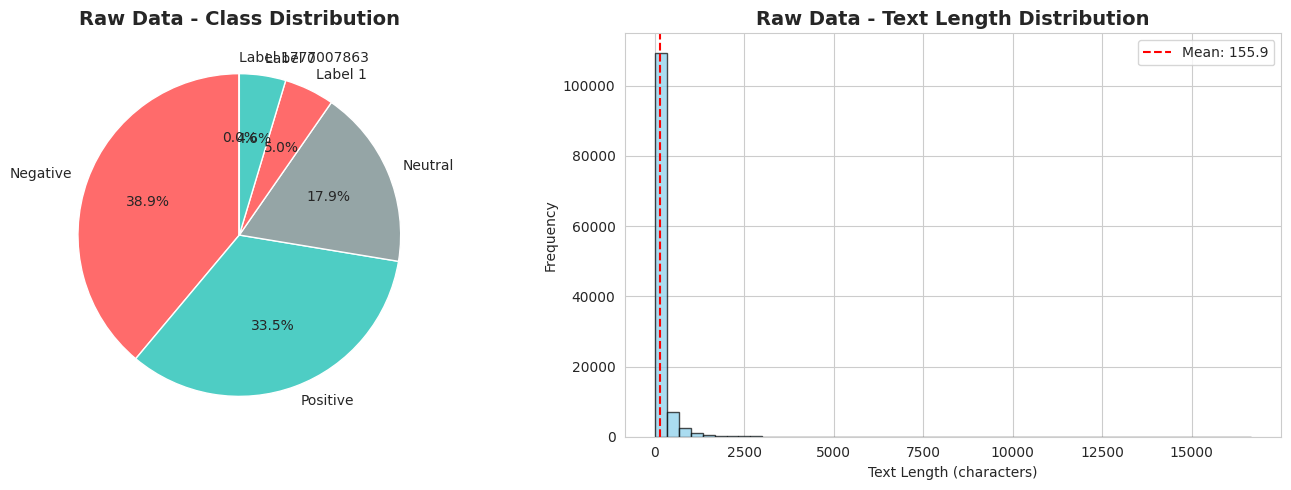


☁️  STEP 3: Generating word cloud BEFORE preprocessing...



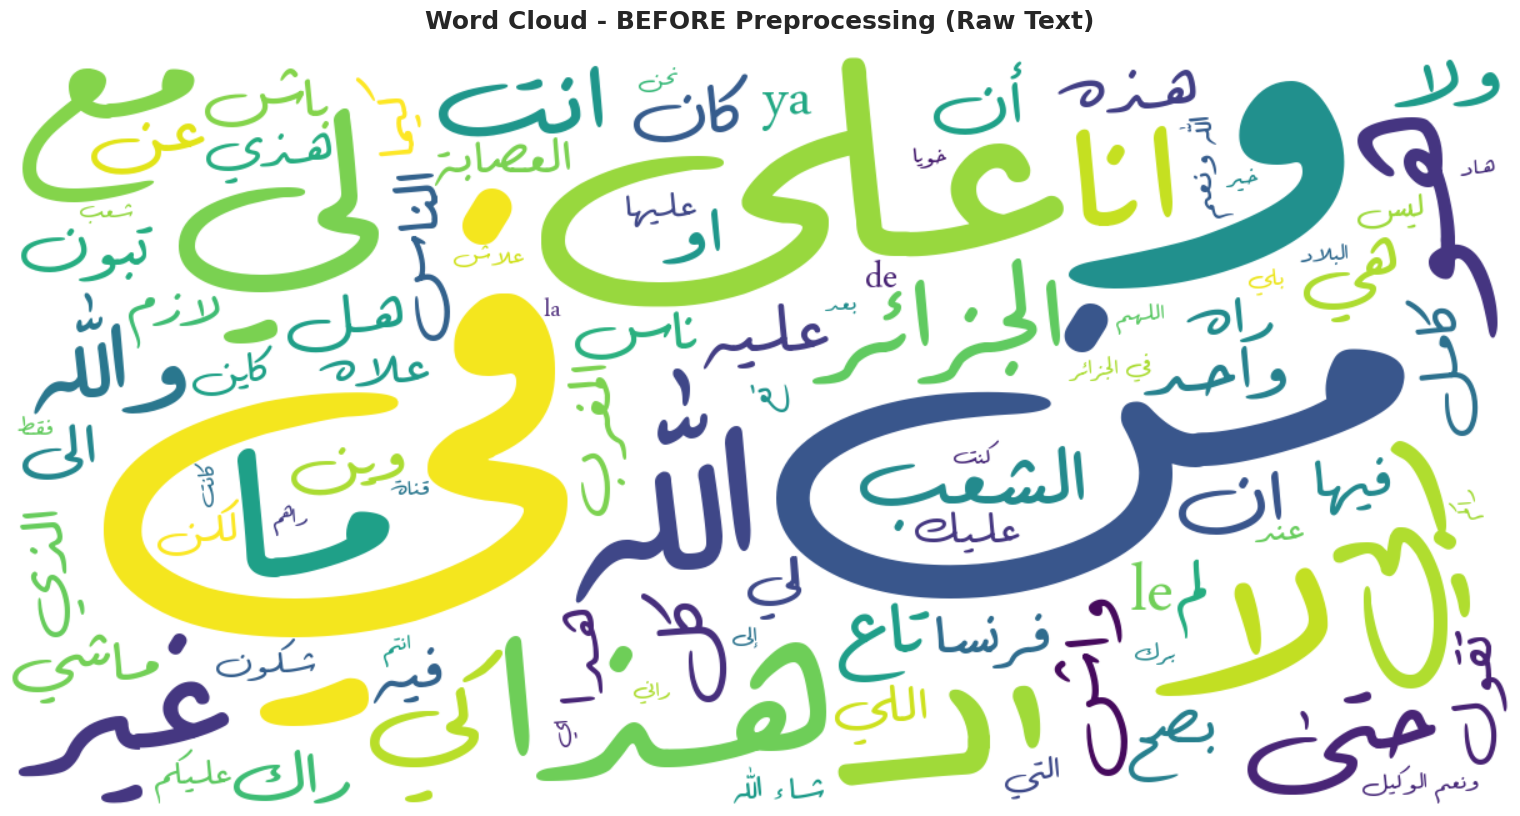


🧹 STEP 4: Preprocessing data...

✅ Cleaned: (84334, 2)
   Retention rate: 69.3%

☁️  STEP 5: Generating word cloud AFTER preprocessing...



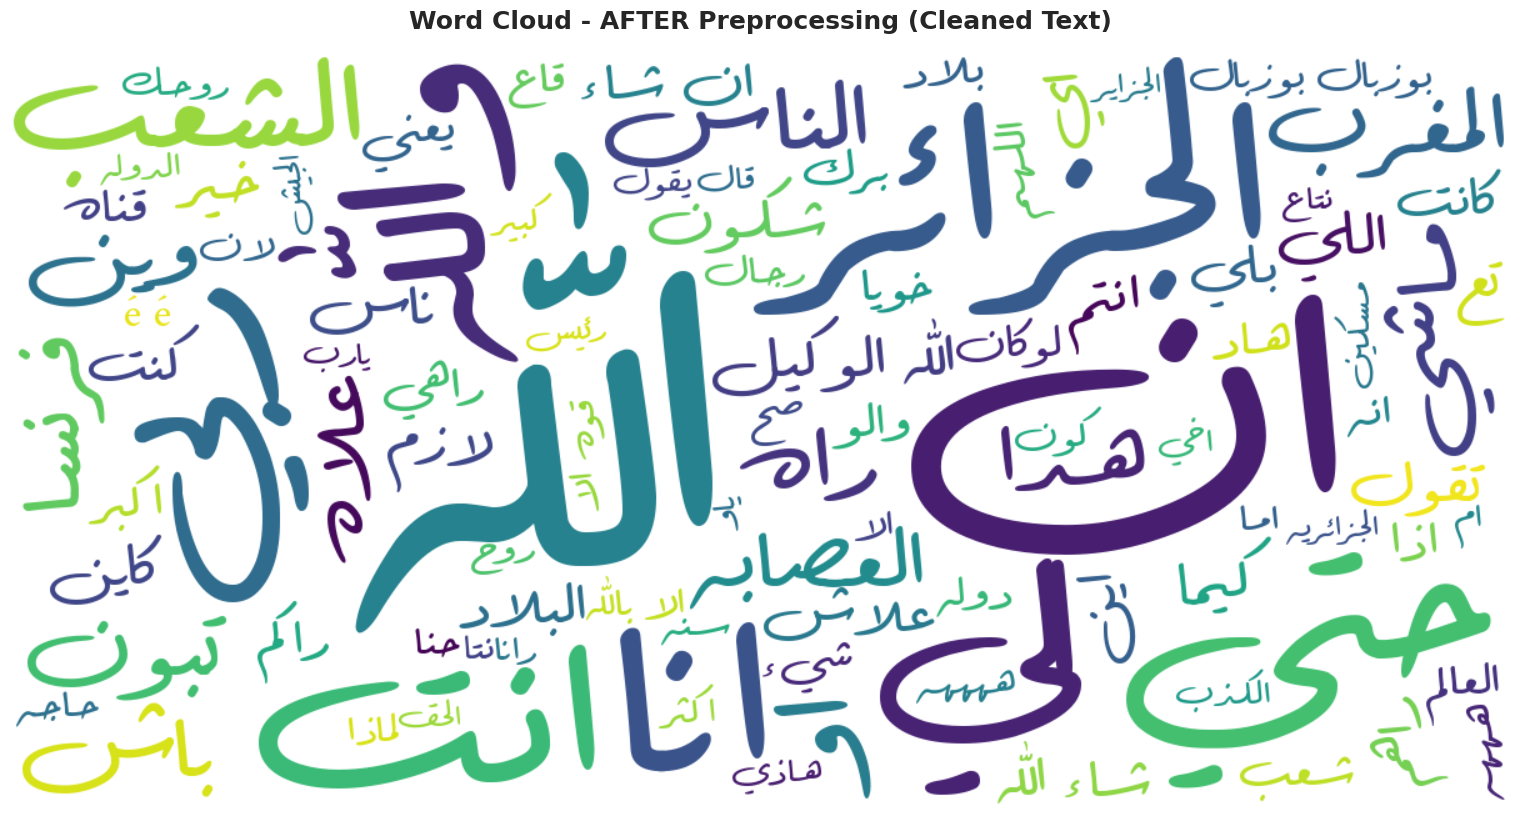


📊 STEP 6: Word frequency analysis...



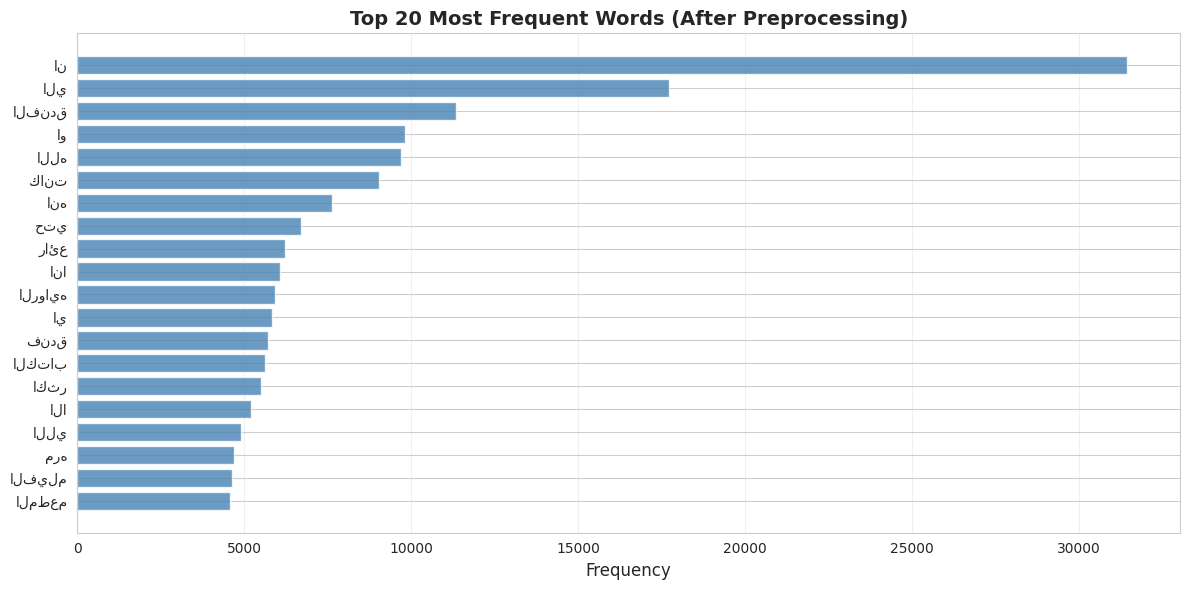


Top 10 words:
    1. ان                   - 31,446 occurrences
    2. الي                  - 17,703 occurrences
    3. الفندق               - 11,330 occurrences
    4. او                   - 9,802 occurrences
    5. الله                 - 9,689 occurrences
    6. كانت                 - 9,040 occurrences
    7. انه                  - 7,608 occurrences
    8. حتي                  - 6,709 occurrences
    9. رائع                 - 6,212 occurrences
   10. انا                  - 6,071 occurrences

🔀 STEP 7: Splitting data...

Train: 59,033, Val: 12,650, Test: 12,651

📚 STEP 8: Building vocabulary...

Vocab size: 50,000 | Max sequence length: 102

🗂️  STEP 9: Creating datasets...

✅ DataLoaders created

🧬 STEP 10: Initializing model...

Total parameters: 10,535,041

🏋️  STEP 11: Training model...

Epoch  1/25 | Train Loss: 0.5480, Acc: 0.7075 | Val Loss: 0.4735, Acc: 0.7644 | Time: 13.3s ⭐
Epoch  2/25 | Train Loss: 0.3953, Acc: 0.8155 | Val Loss: 0.4563, Acc: 0.7790 | Time: 12.1s ⭐
Epoch  3

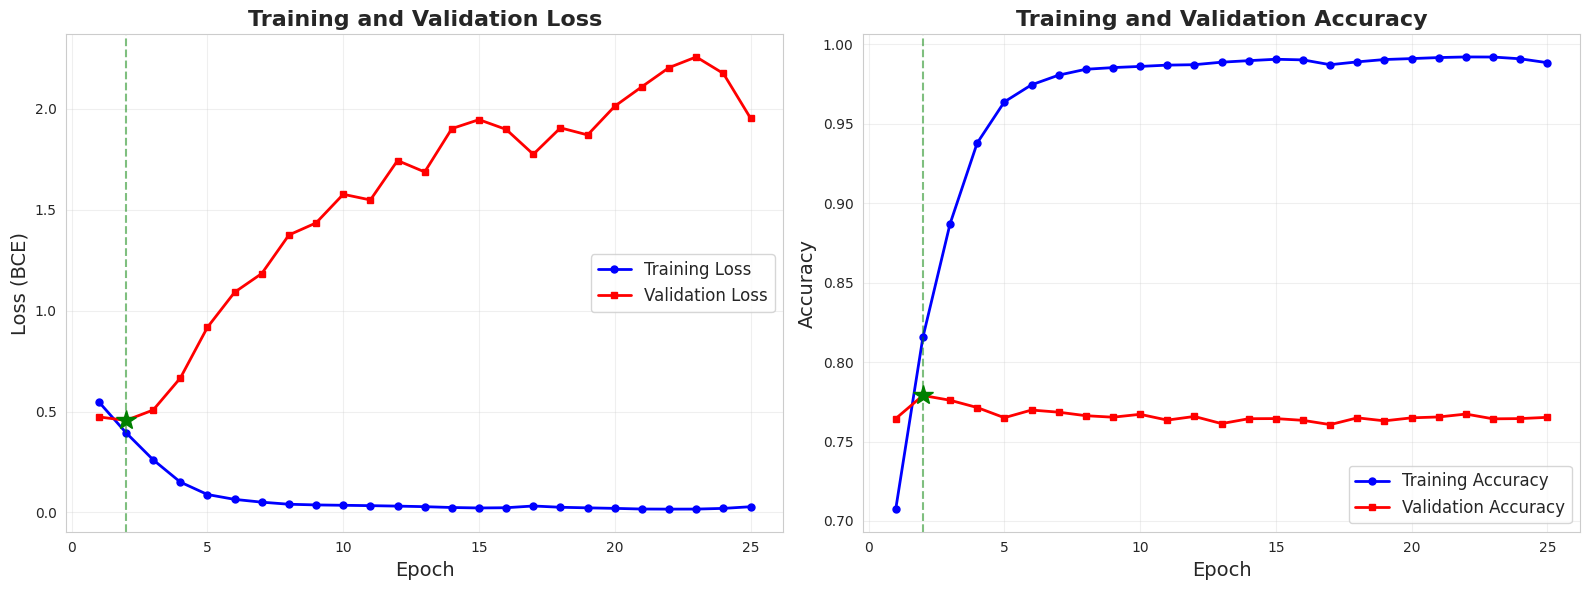


🎯 STEP 13: Evaluating on test set...

TEST RESULTS
Test Loss: 0.4697
Test Accuracy: 0.7707 (77.07%)

              precision    recall  f1-score   support

    Negative       0.77      0.81      0.79      6766
    Positive       0.77      0.72      0.75      5885

    accuracy                           0.77     12651
   macro avg       0.77      0.77      0.77     12651
weighted avg       0.77      0.77      0.77     12651


📊 STEP 14: Plotting confusion matrix...



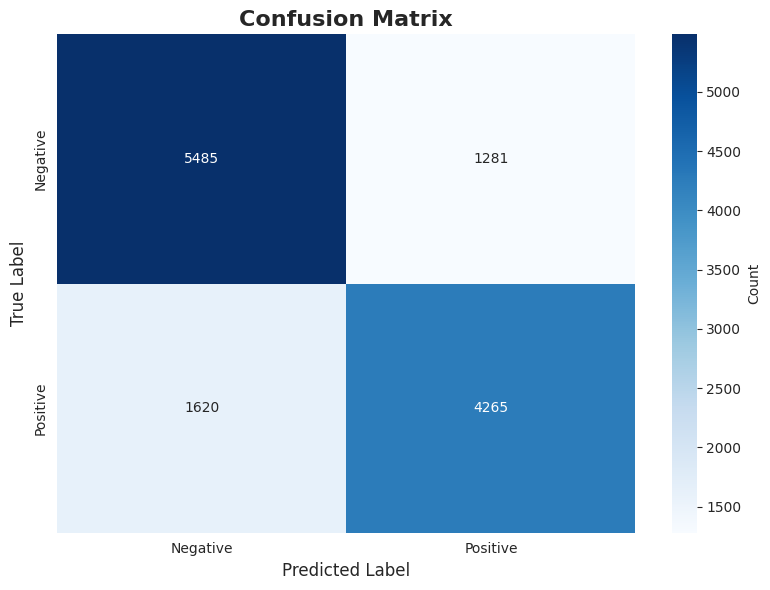


💾 STEP 15: Saving artifacts...

✅ Saved: best_model.pt, vocab.json, meta.json

🗣️  STEP 16: Quick inference demo...

🟢 واش راك اليوم؟ الخدمة مليحة والحمد لله
   → Positive (72.42%)

🔴 ياكلو في حق الشعب
   → Negative (48.96%)

✅ PIPELINE COMPLETED SUCCESSFULLY!


In [ ]:
# Run with 25 epochs
model, vocab, max_len, stop, device = run_full_pipeline(epochs=25, batch_size=256)

---

## 🧪 11. Test the Model - Interactive Testing

Now you can test the trained model with your own text!

In [ ]:
def test_sentiment(text, model, vocab, max_len, device, stopwords):
    """Test sentiment for any text"""
    print(f"\n{'='*80}")
    print(f"🗣️  Original Text: {text}")
    print(f"{'='*80}")

    # Clean
    cleaned = clean_text(text)
    print(f"🧹 Cleaned: {cleaned}")

    # Remove stopwords
    processed = " ".join([w for w in cleaned.split() if w not in stopwords])
    print(f"🔧 Processed: {processed}")

    if not processed.strip():
        print("❌ Text is empty after preprocessing")
        return

    # Predict
    ids = torch.tensor([encode_text(processed, vocab, max_len)], device=device)
    with torch.no_grad():
        prob = torch.sigmoid(model(ids)).item()

    pred = "POSITIVE" if prob >= 0.5 else "NEGATIVE"
    confidence = prob if prob >= 0.5 else (1 - prob)

    # Display results
    emoji = "🟢" if pred == "POSITIVE" else "🔴"
    print(f"\n{emoji} Sentiment: {pred}")
    print(f"📊 Confidence: {confidence*100:.2f}%")
    print(f"\n📈 Probabilities:")
    print(f"   Positive: {prob:.4f} ({prob*100:.2f}%)")
    print(f"   Negative: {1-prob:.4f} ({(1-prob)*100:.2f}%)")
    print(f"\n{'='*80}\n")

print("✅ Test function ready!")

✅ Test function ready!


### Test with Sample Texts

In [ ]:
# Sample texts to test
sample_texts = [
    "هذا المنتج رائع جدا أنصح به",
    "الخدمة سيئة جدا ولن أعود",
    "المطعم نظيف والأكل لذيذ",
    "التوصيل متأخر والمنتج مكسور",
    "تجربة ممتازة وسعر مناسب",
    "واش راك اليوم؟ الخدمة مليحة",
    "ياكلو في حق الشعب"
]

print("🧪 Testing with sample texts...\n")

for i, text in enumerate(sample_texts, 1):
    print(f"\n--- Test {i}/{len(sample_texts)} ---")
    test_sentiment(text, model, vocab, max_len, device, stop)

🧪 Testing with sample texts...


--- Test 1/7 ---

🗣️  Original Text: هذا المنتج رائع جدا أنصح به
🧹 Cleaned: هذا المنتج رائع جدا انصح به
🔧 Processed: المنتج رائع انصح

🟢 Sentiment: POSITIVE
📊 Confidence: 90.35%

📈 Probabilities:
   Positive: 0.9035 (90.35%)
   Negative: 0.0965 (9.65%)



--- Test 2/7 ---

🗣️  Original Text: الخدمة سيئة جدا ولن أعود
🧹 Cleaned: الخدمه سيئه جدا ولن اعود
🔧 Processed: الخدمه سيئه اعود

🔴 Sentiment: NEGATIVE
📊 Confidence: 94.30%

📈 Probabilities:
   Positive: 0.0570 (5.70%)
   Negative: 0.9430 (94.30%)



--- Test 3/7 ---

🗣️  Original Text: المطعم نظيف والأكل لذيذ
🧹 Cleaned: المطعم نظيف والاكل لذيذ
🔧 Processed: المطعم نظيف والاكل لذيذ

🟢 Sentiment: POSITIVE
📊 Confidence: 99.57%

📈 Probabilities:
   Positive: 0.9957 (99.57%)
   Negative: 0.0043 (0.43%)



--- Test 4/7 ---

🗣️  Original Text: التوصيل متأخر والمنتج مكسور
🧹 Cleaned: التوصيل متاخر والمنتج مكسور
🔧 Processed: التوصيل متاخر والمنتج مكسور

🟢 Sentiment: POSITIVE
📊 Confidence: 65.42%

📈 Probabilities:

### Try Your Own Text!

In [ ]:
# ✍️ Write your own text here and run this cell!

your_text = "اكتب النص هنا"  # Replace with your text

# Uncomment the line below to test:
# test_sentiment(your_text, model, vocab, max_len, device, stop)

### Batch Testing with Visualization

📊 Batch Test Results:

                     Text Sentiment Confidence Pos_Prob Neg_Prob
المنتج ممتاز والسعر مناسب  POSITIVE     96.02%   0.9602   0.0398
         الجودة رديئة جدا  NEGATIVE     99.31%   0.0069   0.9931
      خدمة العملاء ممتازة  POSITIVE     96.11%   0.9611   0.0389
      التجربة سيئة للغاية  NEGATIVE     98.28%   0.0172   0.9828
    أنصح بهذا المكان بشدة  POSITIVE     78.69%   0.7869   0.2131


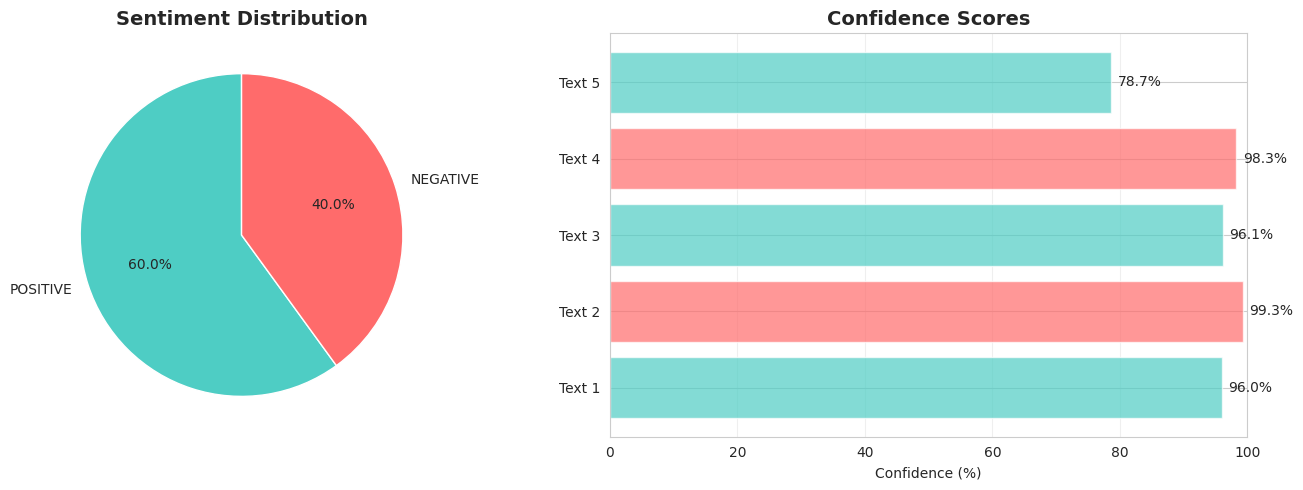

In [ ]:
# Test multiple texts at once
def batch_test(texts, model, vocab, max_len, device, stopwords):
    """Test multiple texts and return results as DataFrame"""
    results = []

    for text in texts:
        cleaned = clean_text(text)
        processed = " ".join([w for w in cleaned.split() if w not in stopwords])

        if processed.strip():
            ids = torch.tensor([encode_text(processed, vocab, max_len)], device=device)
            with torch.no_grad():
                prob = torch.sigmoid(model(ids)).item()

            pred = "POSITIVE" if prob >= 0.5 else "NEGATIVE"
            confidence = prob if prob >= 0.5 else (1 - prob)

            results.append({
                "Text": text[:50] + "..." if len(text) > 50 else text,
                "Sentiment": pred,
                "Confidence": f"{confidence*100:.2f}%",
                "Pos_Prob": f"{prob:.4f}",
                "Neg_Prob": f"{1-prob:.4f}"
            })

    return pd.DataFrame(results)

# Example batch
batch_texts = [
    "المنتج ممتاز والسعر مناسب",
    "الجودة رديئة جدا",
    "خدمة العملاء ممتازة",
    "التجربة سيئة للغاية",
    "أنصح بهذا المكان بشدة"
]

print("📊 Batch Test Results:\n")
results_df = batch_test(batch_texts, model, vocab, max_len, device, stop)
print(results_df.to_string(index=False))

# Visualize
if len(results_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Sentiment distribution
    sentiment_counts = results_df['Sentiment'].value_counts()
    colors = ['#4ecdc4' if s == 'POSITIVE' else '#ff6b6b' for s in sentiment_counts.index]
    ax1.pie(sentiment_counts.values, labels=sentiment_counts.index,
            autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Sentiment Distribution', fontsize=14, fontweight='bold')

    # Confidence scores
    results_df['Conf_Val'] = results_df['Confidence'].str.rstrip('%').astype(float)
    colors_bar = ['#4ecdc4' if s == 'POSITIVE' else '#ff6b6b' for s in results_df['Sentiment']]
    ax2.barh(range(len(results_df)), results_df['Conf_Val'], color=colors_bar, alpha=0.7)
    ax2.set_yticks(range(len(results_df)))
    ax2.set_yticklabels([f"Text {i+1}" for i in range(len(results_df))])
    ax2.set_xlabel('Confidence (%)')
    ax2.set_title('Confidence Scores', fontsize=14, fontweight='bold')
    ax2.set_xlim([0, 100])
    ax2.grid(axis='x', alpha=0.3)

    for i, v in enumerate(results_df['Conf_Val']):
        ax2.text(v + 1, i, f'{v:.1f}%', va='center')

    plt.tight_layout()
    plt.show()